# Statistical hypotheses testing

We want to test whether the number of cylinders of an engine has an impact on the fuel consumption.

In [1]:
import pandas as pd
import matplotlib
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
from sklearn import preprocessing

%matplotlib inline

In [2]:
cars = pd.read_csv('data/auto-mpg.data', delim_whitespace=True, 
                       names = ['mpg', 'cylinders', 'displacement','horsepower',
                                'weight', 'acceleration', 'model_year', 'origin', 'name'],
                        na_values='?')
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [3]:
cars.cylinders.unique()

array([8, 4, 6, 3, 5], dtype=int64)

In [4]:
cars.cylinders.value_counts()

4    204
8    103
6     84
3      4
5      3
Name: cylinders, dtype: int64

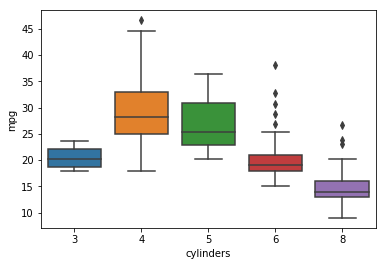

In [5]:
sns.boxplot(x='cylinders', y='mpg', data=cars)

We observe that there are multiple engine types in the data set (based on the number of cylinders). The visualization shows that there is a relationship between the number of cylinders and the fuel consumption (here represented by the number of miles that the car can drive on a single gallon of fuel, i.e., miles per gallon, `mpg`).

We have multiple possibilities how to test the type of this relationship:

* we can test, whether there is a correlation between the two attributes,
* we can try to *fit* a regression model (e.g., a linear one),
* or we can test the differences between the means based on the number of cylinders.

Let us try the last of these. We aim to test the hypothesis that **the difference between the fuel consumption of 6 and 8 cylinder engines is significant**.

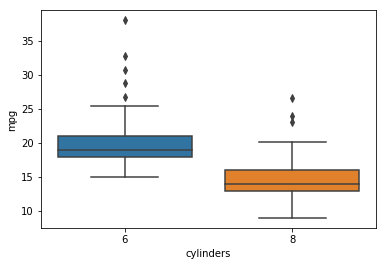

In [6]:
sns.boxplot(x='cylinders', y='mpg', data=cars[(cars.cylinders == 6) | (cars.cylinders == 8)])

There is a difference, that much is clear by visual comparison only. However, in order to test the significance of the observed difference, we need to use a *statistical test*.

![tests](img/tests.png)

We have two independent groups (an engine has either 6 or 8 cylinders, never both). Therefore, we can either use *t-test* or *Mann-Whitney U test*. We always go for t-test, if its assumptions are satisfied.

## Testing the assumptions

### An assumption of the normality of the sample distribution

We can visually assess the normality of the distribution using a histogram or a QQ-plot.

In [7]:
mpg6 = cars.loc[cars.cylinders == 6, 'mpg']

In [8]:
mpg6.describe()

count    84.000000
mean     19.985714
std       3.807322
min      15.000000
25%      18.000000
50%      19.000000
75%      21.000000
max      38.000000
Name: mpg, dtype: float64

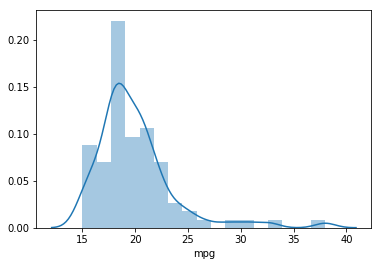

In [9]:
sns.distplot(mpg6)

There are some outliers in the sample. The easiest way how to identify outliers is to use a heuristic based on the interquartile range. Using this heuristic, we can (in case of a normal distribution) consider an observation to be an outlier if it differs more than 1,5-times the interquartile range from the upper or the lower quartile.

In [10]:
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return a[(a > upper) | (a < lower)]

In [11]:
mpg6_out = identify_outliers(mpg6)
mpg6_out

306    28.8
307    26.8
333    32.7
360    30.7
387    38.0
Name: mpg, dtype: float64

In [12]:
mpg6 = mpg6.drop(mpg6_out.index)

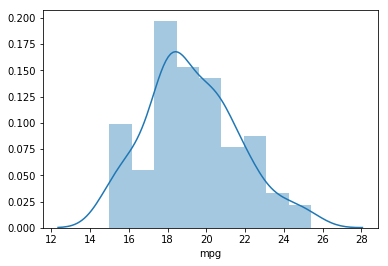

In [13]:
sns.distplot(mpg6)

In [14]:
mpg8 = cars.loc[cars.cylinders == 8, 'mpg']

In [15]:
mpg8.describe()

count    103.000000
mean      14.963107
std        2.836284
min        9.000000
25%       13.000000
50%       14.000000
75%       16.000000
max       26.600000
Name: mpg, dtype: float64

In [16]:
mpg8_out = identify_outliers(mpg8)
mpg8_out

298    23.0
300    23.9
364    26.6
Name: mpg, dtype: float64

In [17]:
mpg8 = mpg8.drop(mpg8_out.index)

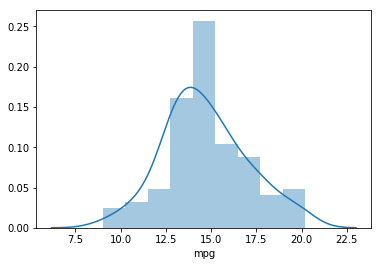

In [18]:
sns.distplot(mpg8)

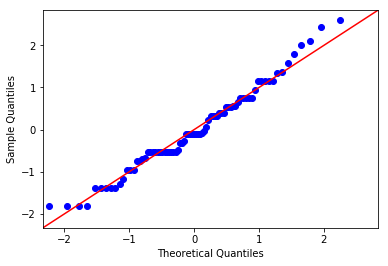

In [19]:
_ = sm.ProbPlot(mpg6, fit=True).qqplot(line='45')

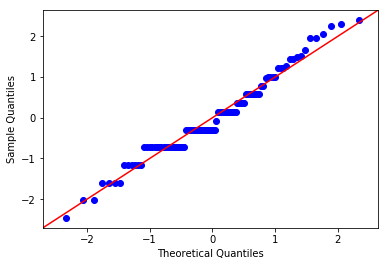

In [20]:
_ = sm.ProbPlot(mpg8, fit=True).qqplot(line='45')

QQ-plot is a visual method of assessing whether the two samples come from the same distribution. In the most cases, we compare the observed sample with a theoretical normal distribution. The data points in the plot represent the values of quantiles in both compared distributions.

#### What questions can QQ-plot answer?

* Do the two set of samples come from the same distribution?
* In a more specific case, does the observed sample come from the tested theoretical distribution (e.g., the normal distribution)?
* Do the two compared distributions have similar values of skewness and kurtosis?

#### How to interpret QQ-plot
https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot

![QQ-plot](img/qq-plot.png)

#### Shapiro-Wilk test of normality

To assess the normality assumption, we can also use **Shapiro-Wilk test** that test a null hypotheses that the data come from the normal distribution. If $p < 0.05$, we reject the null hypothesis and the data come from other than normal distribution. If $p > 0.05$, we do not reject the null hypothesis, i.e., based on the observed data we cannot claim that they come from other than normal distribution.

In [21]:
stats.shapiro(mpg6)

(0.9750953912734985, 0.12478790432214737)

In [22]:
stats.shapiro(mpg8)

(0.9733667373657227, 0.04022931680083275)

The function returns two values - the value of the test statistic (in this case $W$) and the $p$-value. The statistical test tests, whether the value of the test statistic is greater than the critical value. The $p$-value represents the probability that the value of the test statistic would be equal or greater than what we observe and at the same time, the null hypothesis would be true.

The relationship between the test statistic, the $p$-value and the 1st order error $\alpha$ can be seen in the figure below.

![p-value](img/p-value.png)

Source: https://stats.stackexchange.com/questions/124178/why-do-we-compare-p-value-to-significance-level-in-hypothesis-testing-of-mean

Another good source explaining this relationship can be found here: https://blog.minitab.com/blog/adventures-in-statistics-2/understanding-hypothesis-tests-significance-levels-alpha-and-p-values-in-statistics

Based on the test results, the sample of 6 cylinder engines seems to be from a normal distribution, while the 8 cylinder engines sample not. We should use a non-parametric version of the t-test, i.e., **Mann-Whitney U-test** (even though the t-test is quite robust to violation of its assumption given large enough sample size).

### Homogeneity of variance

The second assumption of the t-test is that the variances of the two samples are the same (however, there is a t-test variant that can handle unequal variances). Even though we were not able to confirm the first t-test assumption (concerning the normality of the distributions), let us assess the second nevertheless just for the sake of an exercise.

To test the homogeneity of variances, we can use the **Leven test**. It tests the null hypothesis that all groups of samples come from distributions with the same variances. If we reject the null hypothesis ($p > 0.05$), it means that we cannot claim based on the data that the samples come from the distributions with equal variances.

In [23]:
stats.levene(mpg6, mpg8)

LeveneResult(statistic=0.044821392421680255, pvalue=0.8325763705509353)

Based on the test result, it seems that both sets of samples come from the distributions with the same variance.

### Student t-test vs. Mann-Whiteney U-test

Since the t-test assumptions were not satisfied, we should use its non-parametric version. If they were satisfied, we would use the function `scipy.stats.ttest_ind`.

In [24]:
stats.mannwhitneyu(mpg6, mpg8)

MannwhitneyuResult(statistic=668.0, pvalue=6.202693470007155e-22)

Since $p < 0.001$, the probability of the 1st order error (i.e., that the null hypothesis is true and yet we reject it) is less than 1 per thousand. The observed difference in the fuel consumption bewteen 6 and 8 cylinder engines is statistically significant.

We can visualize the difference between the two means - it is often visualized using bar charts with the *confidence intervals*. The interpretation of a confidence interval is that with N% probability (in the most cases, N = 95) the true value of mean will lie somewhere in the interval.

In [25]:
sms.DescrStatsW(mpg6).tconfint_mean()

(18.73322498793141, 19.793357290549597)

In [26]:
sms.DescrStatsW(mpg8).tconfint_mean()

(14.21682605452332, 15.137173945476686)

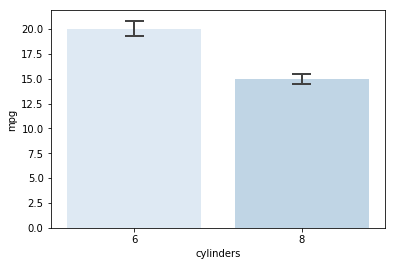

In [27]:
sns.barplot(x='cylinders', y='mpg', data=cars[(cars.cylinders == 8) | (cars.cylinders == 6)], 
            capsize=0.1, errwidth=2, palette=sns.color_palette("Blues"))

## Exercises

a. Analogous to the solution above, test whether the difference in the fuel consumption between 4 and 6 cylinder engines is significant.

b. Analogous to the solution above, test whether the difference in the fuel consumption between 4 and 5 cylinder engines is significant.

Be careful when testing multiple related pairs of data sets. The probability of the 1st order error increases with every additional test. In that case, we should apply correction for multiple tests, such as *Bonferroni correction*. Using this correction, the $p$-value is compared to $\alpha / m$, where $\alpha$ is the accepted 1st order error probability and $m$ is the number of the tested hypotheses.

Or alternative and better way is to use a test that allows to test multiple groups at once. The generalization of the t-test for multiple groups is **ANOVA (Analysis of variance)**.